In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interactive, fixed, IntSlider

# 4.2. Aliasing - 2D signal example:
from PIL import Image
from matplotlib.patches import Rectangle

# 5.1.
import soundfile as sf
from IPython.display import display
from IPython.display import Audio

In [2]:
from matplotlib import rcParams
# rcParams['font.family'] = 'monospace'
rcParams['font.size'] = 16
rcParams['figure.figsize'] = (14, 4) 

# 6. Vzorkování, aliasing a kvantování

V tomto notebooku si ukážeme základní postupy pro zpracování analogového signálu, jeho převedení do diskrétní podoby a následnou rekonstrukci. Budeme se také zabývat problémy, které při tomto postupu nastávají a předvedeme si způsoby, jak jim předcházet nebo je úplně odstranit.

## 1 Vytvoření analogového signálu

Python nemǚže pracovat se spojitými signály. Vygenerujeme jej tedy proto jako diskrétní signál s velmi malou vzorkovací periodou a abychom si předvedli vzorkování, tak jej budeme podvzorkovávat.

Mějme zadaný spojitý signál pomocí funkce:

$$
x(t)=\left[\frac{3}{2}+\frac{3}{10} \sin 2 \pi t+\sin \frac{2 \pi}{3} t-\sin \frac{2 \pi}{10} t\right] \cdot \frac{\sin \pi t}{\pi t} 
$$

Vytvořme si tedy funkci v Pythonu, která nám bude generovat hodnoty této funkce.

In [3]:
def signal_x(t):
    """ Generates our `analog` representation of signal x(t). """
    return (
            +3/2
            +3/10*np.sin(2*np.pi*t)
            +np.sin(2*np.pi/3*t)
            -np.sin(2*np.pi/10*t)
        )* np.sinc(t)

#### _sinc(x)_
neboli *kardinální sinus* je definován jako: $\ \sin(\pi x)/(\pi x)\ $. <br>
Funkce `numpy.sinc` pro hodnotu `0` vrácí její limitní hodnotu v nule.

In [4]:
np.sinc(0)

1.0

#### Zobrazení naší funkce:

In [5]:
N = 10_000
t = np.linspace(-5, 5, N)

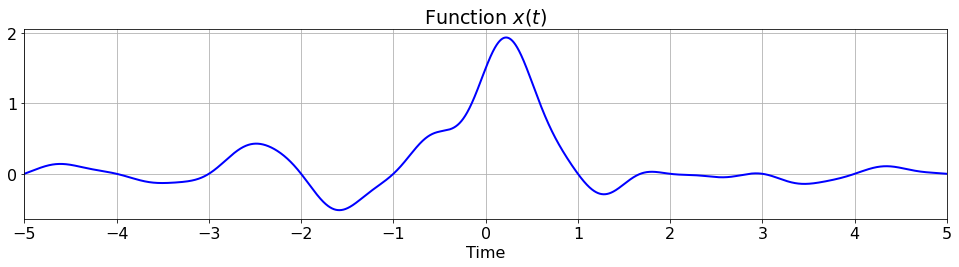

In [6]:
plt.figure()
plt.title('Function $x(t)$')
plt.plot(t, signal_x(t), 'b', linewidth=2)

plt.xlabel('Time')
plt.xticks(np.arange(min(t), max(t)+1))
plt.xlim(min(t), max(t))
plt.grid()
plt.tight_layout()

## 2 Analýza našeho spojitého signálu

Před tím, než vůbec začneme s jakýmkoliv vzorkováním bychom si měli položit otázku ohledně toho, jaký signál vzorkujeme a jestli jsme schopni zjistit z jakých frekvencí je seskládán. Pokud dokážeme signál dobře zanalyzovat, tak dokážeme navrhnout takovou vzorkovací periodu nebo frekvenci, že při zpětné rekonstrukci námi navzorkovaného signálu dostaneme přesně pưvodní analogový signál. Konkrétně nás samozřejmě bude zajímat splnění vzorkovacího teorému, který říká, že vzorkovací frekvence musí být alespoñ dvakrát větší než největší frekvence zastoupená ve vzorkovaném signálu. Neboli:

$$
\Omega_{s}>2 \omega_{\max }
$$

kde $\omega_{\max }$ je nejvyššśi frekvence, kde má ještě signál nějakou energii.
Tedy ještě jednou - mějme definovanou funkci:

$$
x(t)=\left[\frac{3}{2}+\frac{3}{10} \sin 2 \pi t+\sin \frac{2 \pi}{3} t-\sin \frac{2 \pi}{10} t\right] \cdot \frac{\sin \pi t}{\pi t},
$$

kterou si můžeme rozepsat jako

$$
x(t)=x_{1}(t) \cdot x_{2}(t),
$$

kde

$$
\begin{aligned}
&x_{1}(t)=\frac{3}{2}+\frac{3}{10} \sin 2 \pi t+\sin \frac{2 \pi}{3} t-\sin \frac{2 \pi}{10} t \\
&x_{2}(t)=\frac{\sin \pi t}{\pi t}=\text { sinc } t .
\end{aligned}
$$

Fourierovou transformací funkce $x(t)$ získáme její Fourierův obraz.

$$
F(j \omega)=\int_{-\infty}^{\infty} x(t) e^{-j \omega t} d t,
$$

který se dá analogicky podle konvolučního teorému rozepsat

$$
F(j \omega)=\frac{1}{2 \pi} F_{1}(j \omega) * F_{2}(j \omega),
$$

kde operace $*$ značí konvoluci.<br>
Díky tomu můžeme vypočítat Fourierovu transformaci odděleně pro každou funkci $x_1(t)$ a $x_2(t)$

$$
\begin{aligned}
F_{1}(j \omega)=&\ 3 \pi \delta(\omega)+j \frac{3 \pi}{10} \cdot(\delta(\omega+2 \pi)-\delta(\omega-2 \pi))+\\
&+j \pi \cdot\left(\delta\left(\omega+\frac{2 \pi}{3}\right)-\delta\left(\omega-\frac{2 \pi}{3}\right)\right)-j \pi \cdot\left(\delta\left(\omega+\frac{2 \pi}{10}\right)-\delta\left(\omega-\frac{2 \pi}{10}\right)\right), \\
F_{2}(j \omega)=&\ \sqcap\left(\frac{\omega}{2 \pi}\right)=u(\omega+\pi)-u(\omega-\pi),
\end{aligned}
$$

kde obdelníková funkce

$$
\sqcap\left(\frac{\omega}{\tau}\right)=\operatorname{rect}\left(\frac{\omega}{\tau}\right)=u\left(\omega+\frac{\tau}{2}\right)-u\left(\omega-\frac{\tau}{2}\right), \quad \tau=2 \pi,
$$

nabývá hodnot

$$
\operatorname{rect}(k)=\sqcap(k)= \begin{cases}0 & \text { pro }|k|>\frac{1}{2} \\ 1,0 & \text { pro }|k|=\frac{1}{2} \\ 1 & \text { pro }|k|<\frac{1}{2} .\end{cases}
$$

Konvoluce s Diracovým impulsem má specifický výsledek

$$
(\delta * f)(\omega)=\int_{-\infty}^{\infty} \delta(\omega-a) f(a) \mathrm{d} a=f(\omega) .
$$

Výsledný Fourierův obraz bude součtem obdélníkových funkcí s různou amplitudou a šířkou

$$
\begin{aligned}
F(j \omega)=&\ 3 \pi \sqcap(\omega)+j \frac{3 \pi}{10} \sqcap\left(\frac{\omega}{2 \pi}+1\right)-j \frac{3 \pi}{10} \sqcap\left(\frac{\omega}{2 \pi}-1\right)+\\
&+j \pi \sqcap\left(\frac{\omega}{2 \pi}+\frac{1}{3}\right)-j \pi \sqcap\left(\frac{\omega}{2 \pi}-\frac{1}{3}\right)+j \pi \sqcap\left(\frac{\omega}{2 \pi}+\frac{1}{10}\right)-j \pi \sqcap\left(\frac{\omega}{2 \pi}-\frac{1}{10}\right) .
\end{aligned}
$$


Podle hraniční podmínky vychází nejvyšší maximální frekvence $\omega_{\max }$

$$
|k|=\frac{1}{2}, \quad  k=\frac{\omega_{\max }}{2 \pi}-1,
$$

$$
\omega_{\max }=3 \pi .
$$

Vzorkovací frekvence $\Omega_{s}$ by pak měla splňovat vzorkovací teorém

$$
\begin{aligned}
\Omega_{s} &>6 \pi=2 \omega_{\max }, \\
f_{s} &>3, \\
T_{s} &<\frac{1}{3} .
\end{aligned}
$$

## 3 Vzorkování

Jakmile jsme se dozvěděli, jak velká musí být naše vzorkovací perioda, aby byl splněn vzorkovací teorém, můžeme přikročit k samotnému vzorkování. Vzorkovací periodu zvolme třeba $T_{s}=1/4$ a navzorkujme "spojitou" funkci $x(t)$ jako $x[n]=x\left(n T_{s}\right)$.

In [7]:
Ts = 1/4
n = np.arange(-5/Ts, 5/Ts + 1, 1, dtype=int)  # 1 extra point

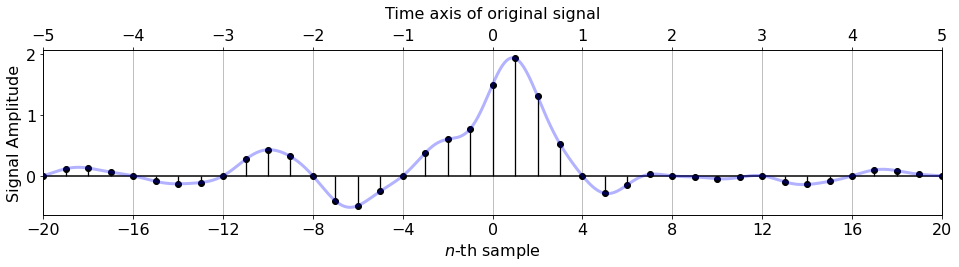

In [8]:
plt.figure()
#plt.title('Sampling of our signal', pad=25)

plt.ylabel('Signal Amplitude')
plt.xlabel('$n$-th sample')
markerline, stemlines, _ = plt.stem(n, signal_x(n * Ts), basefmt="k")  # samples
plt.setp(stemlines, 'color', 'k', 'linewidth', 1.3)
plt.setp(markerline, 'color', 'k', 'markersize', 6)

plt.xlim(min(n), max(n))
plt.xticks([i for i in n[::int(1/Ts)]])
plt.gca().xaxis.grid(True)

# second X axis:
plt.twiny()
plt.xlabel('Time axis of original signal', labelpad=10)
plt.plot(t, signal_x(t), linewidth=3, color='b', alpha=0.3)  # original

plt.xlim(min(t), max(t))
plt.xticks([i for i in range(-5, 5 + 1)])
plt.tight_layout()


### 3.1. Rekonstrukce navzorkovaného signálu
Frekvenčně omezený signál může být přesně rekonstruován pomocí vztahu: 
$$
x(t)=\sum_{n=-\infty}^{\infty} x[n] \operatorname{sinc}\left(\frac{t-n T_{s}}{T_{s}}\right)
$$
Musí být samozřejmě splněn vzorkovací teorém, což jsme si poněkud složitou teorií v tomto případě zajistili.
Rekonstruovaný spojitý signál $x(t)$ se tedy skládá z nekonečného množství škálovaných a posunutých impulzních odezev. Vytvoříme si tedy funkci, pomocí které budeme rekonstruovat náš signál.

In [9]:
def reconstruct_x(t, r, xn, Ts):
    """ Reconstructs original signal value for some time `t` by sum over range r. """
    if type(r) is not range and type(r) is not np.ndarray:
        r = range(-r, r + 1)

    mid = round(len(xn)/2)
    _sum = 0.
    for n in r:  # discrete interval [-r, r]
        _sum += xn[n + mid] * np.sinc((t - n*Ts) / Ts)
    return _sum

In [10]:
# Example how to use reconstruct_x
t = np.linspace(-5, 5, 10_000)
n = np.arange(min(t)/Ts, max(t)/Ts + 1, dtype=int)
xn = signal_x(n * Ts)
r = 4  # choose some range

reconstruct_x(t, r, xn, Ts)

array([-1.84469497e-16,  3.81105681e-05,  7.62310091e-05, ...,
        8.35232004e-05,  4.17555019e-05,  2.73427835e-18])

#### Ukázka rekontrukce $\Sigma\ sinc()$

In [11]:
def ipy_reconstruct(Ts, r_low=0, r_high=0):
    t = np.linspace(-5.0, 5.0, int(1e5))
    n = np.linspace(-5/Ts, 5/Ts, int(2*5/Ts+1))
    
    xn = signal_x(n * Ts)
    
    plt.figure(figsize=(16, 6))
    
    # interval boundaries - red lines
    plt.plot([r_high*Ts, r_high*Ts], [-5, 5], '-', color='#8c2426', linewidth=1.4)
    plt.plot([r_low*Ts, r_low*Ts], [-5, 5], '-', color='#8c2426', linewidth=1.4)

    plt.grid('both')
    #plt.axis([-5, 5, -.75, 2.25])

    plt.plot(t, signal_x(t), '#254e57', linewidth=3.7, alpha=0.2)  # original
    plt.plot(t, reconstruct_x(t, range(r_low, r_high+1), xn, Ts), 'b-', linewidth=2) 

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    if r_low != r_high:
        mid = len(xn)//2
        for _n in range(r_low, r_high+1): 
            plt.plot(t, xn[_n + mid] * np.sinc((t - _n*Ts) / Ts), '--', 
                     linewidth=1.2, alpha=1, color=colors[_n % len(colors)]) 
        text = '$\\sum_{n='+str(r_low)+'}^{'+str(r_high)+'} x[n] sinc\\left(\\frac{t-n T_{s}}{T_{s}}\\right)$'
        plt.text(0.55, 1.8, text, fontsize=24)
    else:
        text = '$x['+str(r_low)+'] sinc\\left(\\frac{t-n T_{s}}{T_{s}}\\right)$'
        plt.text(0.675, 1.9, text, fontsize=24)
        
    plt.xticks(np.linspace(-1, 1, 9, endpoint=True))
    plt.xlim((-1.1, 1.1))
    plt.xlabel('Time', labelpad=20)
    plt.ylabel('Signal Amplitude')
 
    # second X axes
    plt.twiny()
    plt.xlabel('Samples', labelpad=20)
    plt.xticks([i for i in range(-20, 20+1)])
    plt.axis([-4.4, 4.4, -.75, 2.25])

    markerline, stemlines, baseline = plt.stem(n, signal_x(n * Ts), basefmt="k")
    plt.setp(stemlines, 'color', 'k', 'linewidth', 2)
    plt.setp(markerline, 'color', 'k', 'markersize', 8) 
    plt.tight_layout()

In [12]:
iw_low = IntSlider(min=-4, max=4, step=1)
iw_high = IntSlider(min=-4, max=4, step=1)

def update_low(*args): 
    if iw_low.value > iw_high.value: iw_low.value = iw_high.value
def update_high(*args): 
    if iw_high.value < iw_low.value: iw_high.value = iw_low.value
    
iw_high.observe(update_low, 'value')
iw_low.observe(update_high, 'value')

iplot_reconstruct = interactive(
    ipy_reconstruct, 
    Ts=fixed(Ts),
    r_low=iw_low, 
    r_high=iw_high, 
    continuous_update=False
)

In [13]:
iplot_reconstruct

interactive(children=(IntSlider(value=0, description='r_low', max=4, min=-4), IntSlider(value=0, description='…

In [14]:
def ipy_reconstruct_all(Ts, r=0, show_sinc=True):
    """ Interactive example ... """
    t = np.linspace(-5.0, 5.0, 10_000)
    n = np.linspace(-5/Ts, 5/Ts, int(2*5/Ts+1))
    xn = signal_x(n * Ts)

    plt.figure()

    # original vs reconstructed
    plt.plot(t, signal_x(t), '#254e57', linewidth=3.7)  
    plt.plot(t, reconstruct_x(t, r, xn, Ts), 'b-', linewidth=2) 

    # interval boundaries (red lines)
    plt.plot([+r*Ts, +r*Ts], [-5, 5], '#8c2426', linewidth=1.4)
    plt.plot([-r*Ts, -r*Ts], [-5, 5], '#8c2426', linewidth=1.4)
    plt.grid('both')
    
    if show_sinc and r:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        mid = len(xn)//2
        for n in range(-r, r+1):
            plt.plot(t, xn[n + mid] * np.sinc((t - n*Ts) / Ts), 
                     linewidth=0.8, alpha=1, color=colors[n % len(colors)]) 
    # Y
    plt.ylabel('Signal Amplitude')

    # X axis
    plt.xlabel('Time', labelpad=20)
    plt.xticks([i for i in range(-5, 5+1)])
    plt.xlim((-5, 5))

    # second X axis
    plt.twiny()
    plt.xlabel('Interval range', labelpad=20)
    plt.xticks([i for i in range(-20, 20+1, int(1/Ts))])
    plt.axis([-20, 20, -.75, 2.25])
    plt.tight_layout()

In [15]:
iplot_reconstruct_all= interactive(
    ipy_reconstruct_all, 
    Ts=fixed(Ts),
    r=(0, 20), 
    show_sinc=False, 
    continuous_update=False
)
iplot_reconstruct_all.children[-1].layout.height="400px"

#### Ukázka rekonstrukce se všemi vzorky.

In [16]:
iplot_reconstruct_all

interactive(children=(IntSlider(value=0, description='r', max=20), Checkbox(value=False, description='show_sin…

## 4 Aliasing & Anti-aliasing

Aliasing je jev, kdy je vlivem vzorkování původní frekvence spojitého signálu nahrazena úplně jinou frekvencí. K Aliasingu dochází při nedodržení vzorkovacího teorému.

### 4.1. Experimentování s aliasingem

Budeme pokračovat s ruční prací, podíváme na příklady z přednášky. <br>
Ukážeme si případy kdy <b>aliasing</b>
* nenastane 
* nastane 
* nastane a bude odstraněn filtrem typu dolní propust

Nadefinujeme frekvence, osy a indexy: $F_{max} = 3000,\ o_{max} = 6000\pi$.

In [17]:
scenarios = ["WITHOUT ALIASING", 'WITH ALIASING', 'ANTI-ALIASING FILTER']

Fs = 8000  # f_max = 3000
Os = 16000 * np.pi  # o_max = 6000 * np.pi

o = Os/100 * np.arange(-400, 400 + 1)  # 100 per period
gj0 = np.where(o == 0)[0][0]

w_i = np.arange(-300, 300 + 1) + gj0  # indexy na zobr.
w = o[w_i]  # omegy na zobr.

In [18]:
def show_aliasing(X, Xs, Xs_sum, H, Xr, Xaa, example):
    global w, w_i
    fig, axes = plt.subplots(4, 1, figsize= (14, 10), sharex=True,)
    fig.suptitle(example, fontsize=16, y=0.99)
    
    axes[0].set_title('Original')
    axes[0].plot(w, X[w_i], 'b', zorder=1, alpha=1)
    if example == 'ANTI-ALIASING FILTER':  # Show filtered signal
        axes[0].plot(w, Xaa[w_i], 'k--', linewidth=2, zorder=2, label='Low-pass filter')
        axes[0].legend(loc='upper right', fontsize=14)

    axes[1].set_title('Periodically')
    axes[1].plot(w, Xs_sum[w_i], 'b', linewidth=1)
    for xs in Xs:
        axes[1].plot(w, xs[w_i], '--') 

    axes[2].set_title('Reconstruction filter')
    axes[2].plot(w, H[w_i], 'k')
    axes[2].set_yticks(np.linspace(0, 1, 5, endpoint=True)*max(H))
    axes[2].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

    axes[3].set_title('Filtered original')
    axes[3].plot(w, Xr[w_i],'b')

    # Set all axes
    for ax in axes:
        ax.xaxis.grid(True, alpha=0.9, linestyle='-.')
        ax.spines[['right', 'left']].set_visible(False)
        for loc in ['top', 'bottom']:
            ax.spines[loc].set(alpha=0.9, linestyle='-.', linewidth=0.5)
        ax.set_ylim(bottom=0)
        ax.set_xlim(min(w), max(w))
    plt.subplots_adjust(left=0.01, right=0.99, top=0.94, bottom=0.1, hspace=0.35)

In [19]:
def ipy_aliasing(example=scenarios[0]):
    X = np.zeros_like(o)
    Xaa = None
    if example == "WITHOUT ALIASING":
        # 37/100*8000 = 2960 <= 3k
        where = np.arange(-37, 37 + 1) + gj0
        window = np.hamming(2*37 + 1)

        X[where] = window

    elif example == 'WITH ALIASING':
        # 87/100*8000 = 6960 <= 7k
        where = np.arange(-87, 87 + 1) + gj0
        window = np.hamming(2*87 + 1)

        X[where] = window
        
    elif example == 'ANTI-ALIASING FILTER':
        where = np.arange(-87, 87 + 1) + gj0
        window = np.hamming(2*87 + 1) 
        X[where] = window

        # trim Hamming window
        window = window[(88-49):(88+49+1)]

        where = np.arange(-49, 49+1) + gj0
        Xaa = np.zeros_like(o)
        Xaa[where] = window

    # ted periodizovane - okolo -3,-2,-1,0,1,2,3 => 7, 100 per period
    count = 7
    T = 1/Fs
    Xs = np.zeros((count, len(o)))

    shift = np.linspace(-300, 300, count, dtype=int, endpoint=True)
    for i in range(count):
        Xs[i][where + shift[i]] = 1/T * window
    Xs_sum = np.sum(Xs, axis=0)

    # Here we create reconstruction filter
    H = np.zeros_like(o)
    H[np.arange(-50, 50 +1) + gj0] = T

    Xr = H * Xs_sum  # and filter back our original signal
    
    # Show results:
    show_aliasing(X, Xs, Xs_sum, H, Xr, Xaa, example)


iplot_aliasing = interactive(
    ipy_aliasing, 
    example=scenarios,
    continuous_update=False
)
iplot_aliasing.children[-1].layout.height="700px"

In [20]:
display(iplot_aliasing)

interactive(children=(Dropdown(description='example', options=('WITHOUT ALIASING', 'WITH ALIASING', 'ANTI-ALIA…

### 4.2. Aliasing - 2D signál
Dále se podíváme na ukázku aliasingu bude na 2D signálu - obrázku. Zde bude docházet k aliasingu vlivem převzorkování a to konkrétně při zmenšování obrazu.
Všimněte si jak se mění spektrum při použití aliasingového filtru (vysoké frekvence jsou vyfiltrovány).

Obraz tedy budeme zmenšovat, ale vždy následně roztáhne zvětšíme na původní velikost, abychom pořádně viděli výsledek a měli porovnání s originálem (zde ale může také dojít k aliasingu, pro to si můžete zvolit filtr i při zvětšení). Velikost obrázku před zvětšením je ve widgetu naznačena červeným obdelníkem. Při zmenšení a zvětšení obrazu se zdá použít aliasingový filtr. Ukážeme si vliv těchto filtrů na obrázek a jeho spektrum.

In [21]:
img_filter = {'NONE': Image.NEAREST, 'ANTI-ALIASING': Image.ANTIALIAS}  # TODO: param fixed

def ipy_aliasing_img(img=None, shrink=0, show_size=True, show_spectrum=False, 
                     downscale=[], upscale=[]):
    """ Interactive example of 2-D aliasing. """
    Sx = (100-shrink)/100
    Sy = Sx
    size = (round(img.size[0]*Sx), round(img.size[1]*Sy))
    
    # DOWN-SCALE image
    img_sdown = img.resize(size, img_filter[downscale])

    # UP-SCALE back to original size
    img_sup = img_sdown.resize(img.size, img_filter[upscale])

    # Spectrum of resized image
    if show_spectrum:  
        channel = np.asarray(img_sup)[:, :, 0]
        spectrum = np.fft.fftshift(np.log(1 + np.abs(np.fft.fft2(channel))))
    
    fig = plt.figure(figsize=(16, 10))
    ax_img = fig.add_subplot(121)
    ax_img.set_title('Image x:{0:2}%, y:{1:2}%'.format(shrink, shrink), fontsize=16)
    ax_img.imshow(img_sup, 'gray')
    ax_img.spines[['left', 'right', 'top', 'bottom']].set_visible(False)

    xy = img_sdown.size[0]-2.5, img_sdown.size[1]-2.5
    if show_size:
        ax_img.add_patch(Rectangle(
            (0.5, 0.5), *xy, fill=False, lw=1.4, edgecolor='r', alpha=0.8)
        )
    if show_spectrum:
        ax_spec = fig.add_subplot(122)
        ax_spec.set_title(f'2D spectrum', fontsize=16)
        ax_spec.imshow(spectrum, 'magma')
        ax_spec.set_xticks([])
        ax_spec.set_yticks([])
    
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.00)

In [22]:
img = Image.open('barbara.png')  # read as PIL.Image

iplot_aliasing2d = interactive(
    ipy_aliasing_img,
    img=fixed(img),
    shrink=(0, 90, 5),
    show_size=True,
    show_spectrum=True,
    downscale=img_filter.keys(),
    upscale=img_filter.keys(),
    continuous_update=False
)
iplot_aliasing2d.children[-1].layout.height="600px"

In [23]:
iplot_aliasing2d

interactive(children=(IntSlider(value=0, description='shrink', max=90, step=5), Checkbox(value=True, descripti…

## 5 Kvantování

Ve zpracování signálů je kvantování proces, kdy se snažíme reprezentovat spojitý interval hodnot, nebo velké množství diskrétních hodnot relativně malou množinou diskrétních symbolů nebo celých čísel. Typické použití kvantování je převod diskrétního signálu (což je navzorkovaný spojitý signál) do digitální podoby, kterou můžeme například uložit na pevný disk počítače. Příkladem může být třeba hudební CD, na kterém je uložen navzorkovaný analogový signál (vzorkovací frekvence je $44100 \mathrm{~Hz}$) a každý je uložen (nakvantován) na 16 bitech. Každý vzorek tedy může nabývat jednu ze 65536 hodnot.

Jednoduchým způsobem kvantizace je *uniformní* kvantizace. Předpokládejme, že hodnoty našeho signálu se mohou měnit v intervalu $\left[ a,\ b\right]$, tak kvantizační funkce bude mít tvar

$$
x_{Q}=\left\lfloor\frac{x-a}{b-a}\cdot\left(2^{N}-1\right)+\frac{1}{2}\right\rfloor \cdot \frac{b-a}{2^{N}-1}+a,
$$

kde N reprezentuje počet bitů, na kterých bude uložena navzorkovaná hodnota. Signál je rozdělen do N intervalů, které jsou rovnoměrně rozloženy. Tato kvantizační funkce pracuje následovně:
- Signál je převeden do intervalu $\left[0,\ 1\right]$
- Naškálován do rozsahu $\left[0,\ 2^{N}-1\right]$
- Ořezem desetinné čárky (funkce `floor`) vyjádřen celočíselně
- Kvantovaný signál je převeden zpět do intervalu $\left[a,\ b\right]$

In [24]:
def uf_quantization(x: np.ndarray, a: float, b: float, N: int) -> np.ndarray:
    """ Uniform quantization. """
    delta = (b - a)/(2**N - 1)
    return np.floor((x - a)/delta + 1/2) * delta  + a

### 5.1. Kvantování audia

In [25]:
s, fs = sf.read("music.wav")
s = s[:10*fs + 1]  # cut <0, first 10 seconds>

N_bits = 6  # try 2, 4, 6, 8, 12
s_q = uf_quantization(x=s, a=-1, b=1, N=N_bits)

display(Audio(s, rate=fs))    # First is original audio
display(Audio(s_q, rate=fs))  # Second is quantized audio

# sf.write('music_q'+str(N_bits)+'.wav', s_q, Fs)

In [26]:
print(f'N = {N_bits}')
display(Audio(abs(s-s_q), rate=fs))  # Diffrence of original and quantized audi

N = 6


In [27]:
def ipy_sound_quant(sound, n_bits=3, start=3, length=0.01): # show=['', 'DIFFRENCE', 'SCALED DIFFRENCE']):
    """ 
    Interactive quantization of soundwave. 
    `start` of segment in seconds
    `length` of segment in seconds
    """
    s, fs = sound
    s_q = uf_quantization(x=s, a=-1, b=1, N=n_bits)

    s_i = int(start * fs)  # first sample of segment
    e_i = int((start + length) * fs) + 1

    seg_s = s[s_i:e_i]
    seg_q = s_q[s_i:e_i]
    seg_t = np.arange(seg_s.size) / fs + start 

    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_subplot(111)

    ax.set_title(f'Kvantování audia, {n_bits}/16 bitů')
    ax.plot(seg_t, seg_s, 'b', label='Originál')
    ax.plot(seg_t, seg_q, 'r', label='Kvantovaný')
    ax.plot(seg_t, 0*seg_t, 'k--', alpha=0.5)
    ax.legend(bbox_to_anchor=(0.9, 1.2))

    ax.set_xlim(start, start+length)
    ylim = (-1.01, 1.01)
    for h in np.arange(0.9, 0, -0.1): #[0.9, 0.25, 0.125]:
        if abs(seg_q).max() <= h:
            ylim = (ylim[0]+0.1, ylim[1]-0.1) 
    ax.set_ylim(ylim)

    # First and Last sample of segment, top x-axis:
    plt.twiny()
    plt.xticks([s_i, e_i])
    plt.xlim(s_i, e_i)
    plt.subplots_adjust(left=0.0, right=1, top=1, bottom=0.0, wspace=0.05)
 

In [28]:
iplot_sound_quant = interactive(
    ipy_sound_quant,
    sound=fixed(sf.read("music.wav")), 
    n_bits=(1, 16),
    start=(0, 10),
    length=(0.01, 0.1, 0.005),
    continuous_update=False
)
iplot_sound_quant.children[-1].layout.height="500px"
display(iplot_sound_quant)

interactive(children=(IntSlider(value=3, description='n_bits', max=16, min=1), IntSlider(value=3, description=…

### 5.2. Kvantování obrazu

Nejprve si načteme několik $8$ bitových obrázku. Zobrazíme si původní obrázek, nakvantovaný, jejich rozdíl a některé metriky pro srovnání. 

In [29]:
def img_quantization(img, n_bits=4):
    """ 8 bits image quantization with RGB color (or grayscale) values in interval 0-255. """
    img = img.astype(float)
    img_q = uf_quantization(x=img, a=0, b=255, N=n_bits)
    return img_q.astype(np.uint8)

In [30]:
names = ['lena.gif', 'lena_rgb.jpg', 'francesca.jpg']
image_set = {}
for name in names:
    image_set[name] = plt.imread(name)  # READ => (save numpy arrays w/ various shapes)

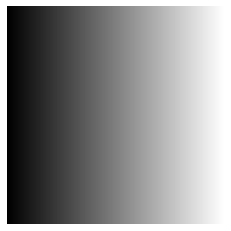

In [31]:
# add one more example:
M = 2
gray_spec = np.ndarray((M*256, M*256), dtype=int)
gray_spec[:,:] = np.arange(M*256, dtype=int) // M 
plt.imshow(gray_spec, interpolation=None, cmap='gray'), plt.axis('off')

names.append('gray spectrum')
image_set[names[-1]] = gray_spec

#### Interaktivní ukázka

In [32]:
def i_img_quantization(image_set, image=names[0], show=['', 'DIFFRENCE', 'SCALED DIFFRENCE'], n_bits=3):
    """ Interactive quantization of images. """
    orig = image_set[image]  # picked image
    img_q = img_quantization(orig, n_bits)
    
    c = 3 if show else 2 
    _, ax = plt.subplots(1, c, figsize=(7*c, 10)) 

    ax[0].set_title(f'Originál [{image}]')
    ax[0].imshow(orig, 'gray')

    ax[1].set_title(f'Nakvantovaný [{image}] {n_bits}/8 bits')
    ax[1].imshow(img_q, 'gray')
    
    # Show info
    stats = '' \
        + 'Mean-squared error  :{0:8.2f}    \n'.format(np.square(np.subtract(orig.astype(float), img_q.astype(float))).mean()) \
        + 'AVG error per pixel :{0:8.2f} %\n\n'.format(np.sum(np.abs(np.subtract(orig.astype(float), img_q.astype(float))))/orig.shape[0]/orig.shape[1]) \
        + 'Pixels data memory  :{0:8.2f} %  \n'.format(100 * (n_bits / 8)) # VTODO: delta^2 
    ax[1].text(0, orig.shape[0]+150, stats)
    
    # Diffrence result image
    if show:  
        s = ''
        d_scale = 1
        if show == 'SCALED DIFFRENCE':
            if n_bits < 8:
                d_scale = 2**n_bits
            s = ' (scaled by: {0})'.format(d_scale) 
        diff = d_scale * abs(orig.astype(int) - img_q.astype(int))  #.astype(np.uint8)
        diff = np.where(diff < 255, diff, 255)

        ax[2].set_title('Diffrence' + s)
        ax[2].imshow(diff, 'gray', vmin=0, vmax=255) 

    for _ax in ax:
        _ax.set_xticks([])
        _ax.set_yticks([])
    #plt.subplots_adjust(left=0.0, right=1, top=1, bottom=0.0, wspace=0.05)
    plt.tight_layout()

iplot_img_quant = interactive(
    i_img_quantization,
    image_set=fixed(image_set), 
    image=names, # (1, len(image_set)), 
    n_bits=(1, 8),
    continuous_update=False
)
iplot_img_quant.children[-1].layout.height="700px"

In [33]:
iplot_img_quant

interactive(children=(Dropdown(description='image', options=('lena.gif', 'lena_rgb.jpg', 'francesca.jpg', 'gra…

# // ----- // ------ //